# 📌 Previsões com Confiança + Backtest + Gráfico com Setas
Neste notebook, usamos o modelo RandomForest para prever movimentos de alta em um ativo financeiro.
Incluímos:
- Previsões com `predict_proba`
- Backtest com entrada apenas quando a confiança for alta
- Gráfico de candles com setas onde o modelo previu compra


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('ggplot')

In [4]:
ticker = 'AAPL'
df = pd.read_csv(f'../data/{ticker}_ativo_com_indicadores.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.dropna(inplace=True)

In [5]:
# Criar alvo para prever alta significativa
df['target'] = df['close'].shift(-3)
df['target_class'] = np.where(df['target'] > df['close'] * 1.002, 1,
                         np.where(df['target'] < df['close'] * 0.998, 0, -1))
df = df[df['target_class'] != -1]

In [6]:
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_signal',
            'sma_20', 'ema_20', 'bb_upper', 'bb_lower']

X = df[features]
y = df['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

modelo = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
modelo.fit(X_res, y_res)

probs = modelo.predict_proba(X_test)[:, 1]  # probabilidade da classe 1 (alta)
limiar = 0.7  # confiança mínima para comprar
df_test = df.iloc[-len(X_test):].copy()
df_test['proba_alta'] = probs
df_test['sinal_compra'] = (df_test['proba_alta'] > limiar).astype(int)

In [7]:
capital = 10000
retornos = []
for i in range(len(df_test) - 3):
    if df_test['sinal_compra'].iloc[i] == 1:
        preco_entrada = df_test['close'].iloc[i]
        preco_saida = df_test['close'].iloc[i + 3]
        retorno = (preco_saida - preco_entrada) / preco_entrada
    else:
        retorno = 0
    retornos.append(retorno)

capital_acumulado = [capital]
for r in retornos:
    capital *= (1 + r)
    capital_acumulado.append(capital)

In [8]:
precos = df_test['close'].values
bh_inicial = precos[0]
capital_bh = [capital_acumulado[0] * (precos[i] / bh_inicial) for i in range(len(capital_acumulado))]

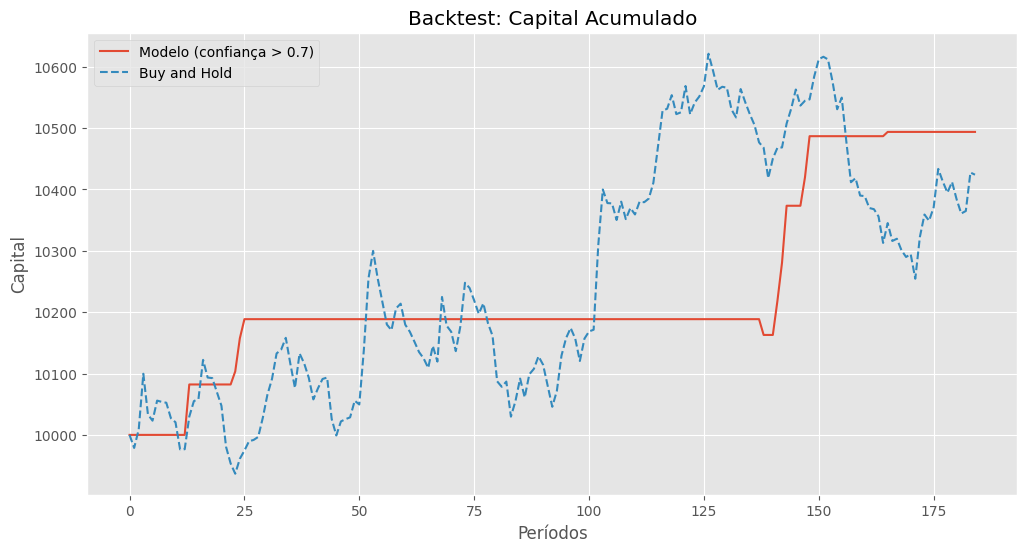

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(capital_acumulado, label=f'Modelo (confiança > {limiar})')
plt.plot(capital_bh, label='Buy and Hold', linestyle='--')
plt.title('Backtest: Capital Acumulado')
plt.xlabel('Períodos')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import plotly.offline as pyo

def plotar_candles_com_setas(df_test, limiar=0.7):
    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df_test.index,
        open=df_test['open'],
        high=df_test['high'],
        low=df_test['low'],
        close=df_test['close'],
        name='Candlestick'
    ))

    for i in range(len(df_test) - 3):
        if df_test['proba_alta'].iloc[i] > limiar:
            preco = df_test['low'].iloc[i] * 0.995
            fig.add_annotation(
                x=df_test.index[i],
                y=preco,
                showarrow=True,
                arrowhead=3,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="green",
                text="🟢 Compra"
            )

    fig.update_layout(
        title=f'📈 Sinais de Compra com Confiança > {limiar}',
        xaxis_title='Data',
        yaxis_title='Preço',
        xaxis_rangeslider_visible=False,
        height=700
    )

    # 👉 Abrir no navegador como HTML
    pyo.plot(fig, filename='grafico_com_setas.html', auto_open=True)

# 🔁 Chamada
plotar_candles_com_setas(df_test, limiar=0.7)
